In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import tensorflow as tf
from keras import backend as K
from tensorflow.keras import layers
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.optimizers import Adam, SGD, RMSprop

In [3]:
import numpy as np 
import pandas as pd 
import nibabel as nib
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt

In [4]:
%matplotlib inline
import nibabel
import matplotlib.pyplot as plt
import numpy as np

In [5]:
data = pd.read_csv('C:/Users/kzhan/Desktop/archive/metadata.csv')
file_path1 = os.path.join('C:/Users/kzhan/Desktop/archive/ct_scans')
data.head(n=5)

,ct_scan,lung_mask,infection_mask,lung_and_infection_mask
0,C:/Users/kzhan/Desktop/archive/ct_scans/corona...,C:/Users/kzhan/Desktop/archive/lung_mask/coron...,C:/Users/kzhan/Desktop/archive/infection_mask/...,C:/Users/kzhan/Desktop/archive/lung_and_infect...
1,C:/Users/kzhan/Desktop/archive/ct_scans/corona...,C:/Users/kzhan/Desktop/archive/lung_mask/coron...,C:/Users/kzhan/Desktop/archive/infection_mask/...,C:/Users/kzhan/Desktop/archive/lung_and_infect...
2,C:/Users/kzhan/Desktop/archive/ct_scans/corona...,C:/Users/kzhan/Desktop/archive/lung_mask/coron...,C:/Users/kzhan/Desktop/archive/infection_mask/...,C:/Users/kzhan/Desktop/archive/lung_and_infect...
3,C:/Users/kzhan/Desktop/archive/ct_scans/corona...,C:/Users/kzhan/Desktop/archive/lung_mask/coron...,C:/Users/kzhan/Desktop/archive/infection_mask/...,C:/Users/kzhan/Desktop/archive/lung_and_infect...
4,C:/Users/kzhan/Desktop/archive/ct_scans/corona...,C:/Users/kzhan/Desktop/archive/lung_mask/coron...,C:/Users/kzhan/Desktop/archive/infection_mask/...,C:/Users/kzhan/Desktop/archive/lung_and_infect...


In [6]:
def read_nii(file_path):
    ct_scan = nib.load(file_path)
    array   = ct_scan.get_fdata()
    array   = np.rot90(np.array(array))
    return(array)

In [7]:
sample_ct   = read_nii(data.loc[0,'ct_scan'])
sample_lung = read_nii(data.loc[0,'lung_mask'])
sample_infe = read_nii(data.loc[0,'infection_mask'])
sample_all  = read_nii(data.loc[0,'lung_and_infection_mask'])

Text(0.5, 1.0, 'Mask of Lungs of Original')

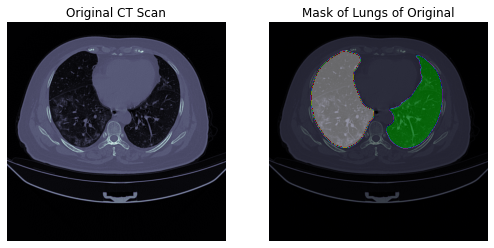

In [8]:
fig = plt.figure(figsize = (18,15))
plt.subplot(1,4,1)
plt.imshow(sample_ct[..., 125], cmap = 'bone')
plt.axis("off")
plt.title('Original CT Scan')

plt.subplot(1,4,2)
plt.imshow(sample_ct[..., 125], cmap = 'bone')
plt.imshow(sample_lung[..., 125],alpha = 0.5, cmap = 'nipy_spectral')
plt.axis("off")
plt.title('Mask of Lungs of Original')

In [9]:
def plot_normal(array_list, color_map = 'nipy_spectral'):
    fig = plt.figure(figsize=(18,15))

    plt.subplot(1,4,1)
    plt.imshow(array_list[0], cmap='bone')
    plt.axis("off")
    plt.title('Original Image')

    plt.subplot(1,4,2)
    plt.imshow(array_list[0], cmap='bone')
    plt.imshow(array_list[1], alpha=0.5, cmap=color_map)
    plt.axis("off")
    plt.title('Lung Mask')
    plt.show()

def plt_infections(array_list, color_map = 'nipy_spectral'):
    fig = plt.figure(figsize = (18, 15))

    plt.subplot(1,4,3)
    plt.imshow(array_list[0], cmap='bone')
    plt.imshow(array_list[0], alpha=0.5, cmap=color_map)
    plt.axis("off")
    plt.title('Infection Mask')

    plt.subplot(1,4,4)
    plt.imshow(array_list[0], cmap='bone')
    plt.imshow(array_list[1], alpha=0.5, cmap=color_map)
    plt.axis("off")
    plt.title('Lung and Infection Mask')

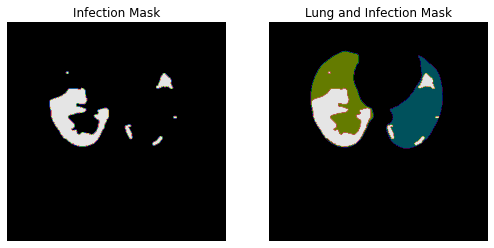

In [11]:
plt_infections([sample_infe[...,120], sample_all[...,120]])

In [12]:
lungs = []
infections = []
img_size = 128

for i in range(len(data)):
    ct = read_nii(data['ct_scan'][i])
    infect = read_nii(data['infection_mask'][i])
    
    for ii in range(ct.shape[0]):
        lung_img = cv2.resize(ct[ii], 
        dsize = (img_size, img_size),interpolation = cv2.INTER_AREA).astype('uint8')

        infec_img = cv2.resize(infect[ii],
        dsize=(img_size, img_size),interpolation = cv2.INTER_AREA).astype('uint8')
        
        lungs.append(lung_img[..., np.newaxis])
        infections.append(infec_img[..., np.newaxis])

In [13]:
lungs = np.array(lungs)
infections = np.array(infections)

print(f"The shape of the lung CT scans is {lungs.shape}.")
print(f"The shape of the infection masks is {infections.shape}.")

The shape of the lung CT scans is (11191, 128, 128, 1).
The shape of the infection masks is (11191, 128, 128, 1).


In [14]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

from tensorflow.keras.regularizers import * 


def build_model(input_layer, start_neurons):
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(0.25)(pool1)

    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(0.5)(pool2)

    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(0.5)(pool3)

    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(pool3)
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(0.5)(pool4)

    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(pool4)
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(convm)

    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(0.5)(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)

    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(0.5)(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)

    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.5)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)

    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.5)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)

    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    
    return output_layer

input_layer = Input((img_size, img_size, 1))
output_layer = build_model(input_layer, 16)

In [15]:
from sklearn.model_selection import train_test_split
lung_train, lung_test, infect_train, infect_test = train_test_split(lungs, infections, test_size = 0.1)

In [16]:
output = build_model(input_layer, 16)
model = Model(input_layer, output_layer)

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 2320        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 16)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [18]:
history = model.fit(lung_train, infect_train, epochs = 10, validation_data = (lung_test, infect_test))

Epoch 1/10
 21/315 [=>............................] - ETA: 5:55 - loss: 0.4690 - accuracy: 0.9109

KeyboardInterrupt: 

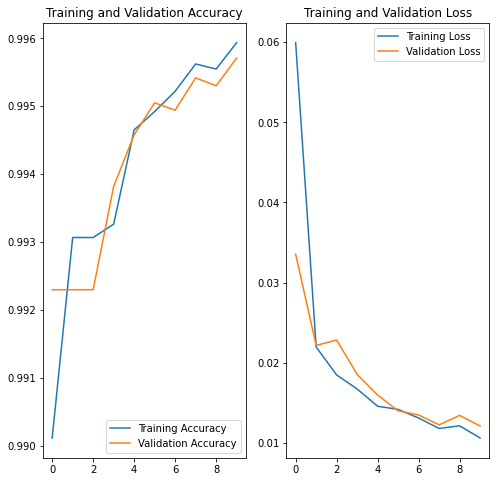

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = 10

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Text(0.5, 1.0, 'predicted infection mask')

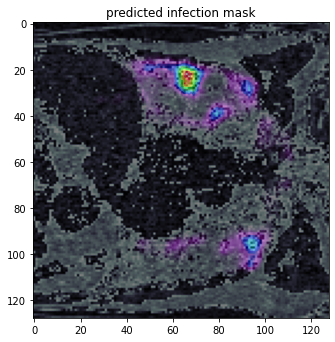

In [ ]:
predicted = model.predict(lung_test)

fig = plt.figure(figsize = (18,15))

plt.subplot(1,3,3)
plt.imshow(lung_test[550][...,0], cmap = 'bone')
plt.imshow(predicted[550][...,0],alpha = 0.5,cmap = "nipy_spectral")
plt.title('predicted infection mask')

In [ ]:
model.save('lung_seg.h5')

In [ ]:
model.save_weights('lung_seg_weights.ckpt')